In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import os
import numpy as np
import PIL

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preprocessing Imgae

In [2]:
height = 224
width = 224
channels = 3
img_shape = (height, width, channels)
img_size = (height, width)

In [3]:
TRAINING_DIR = "/kaggle/input/dataset-food-indonesia-42/Train"
VALIDATION_DIR = "/kaggle/input/dataset-food-indonesia-42/Val"
TEST_DIR = "/kaggle/input/dataset-food-indonesia-42/Test"

In [4]:
# Make Labels
classes = os.listdir(TRAINING_DIR)
with open('food_labels.txt', 'w') as f:
    for food_class in classes:
        f.write(f'{food_class}\n')

train_datagen = ImageDataGenerator(
                rescale = 1./255,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    batch_size=128,
                                                    target_size=img_size)

Found 10080 images belonging to 42 classes.


In [5]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              class_mode='categorical',
                                                              batch_size=128,
                                                              target_size=img_size)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  class_mode = 'categorical',
                                                  batch_size=128,
                                                  target_size = img_size,
                                                  shuffle = False)

Found 1260 images belonging to 42 classes.
Found 1260 images belonging to 42 classes.


In [6]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 224, 224, 3)
(128, 42)


# Build Model

In [7]:
# Callback EarlyStopping untuk menghentikan pelatihan jika val_loss tidak berkurang
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', patience=10)

# Model menggunakan pre-trained MobileNetV2
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')

# Membuat model sederhana di atas pre-trained MobileNetV2
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(42, activation='softmax')
])


9406464/9406464 [==============================] - 0s 0us/step


In [8]:
# Mengatur model untuk pelatihan
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Menampilkan ringkasan model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

# Training Model

In [9]:
# Pelatihan model dengan menggunakan callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping_callback]
)

Epoch 1/20
33/79 [===========>..................] - ETA: 2:30 - loss: 4.3138 - accuracy: 0.0762

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


79/79 [==============================] - 316s 4s/step - loss: 3.5658 - accuracy: 0.1745 - val_loss: 2.5145 - val_accuracy: 0.3389
Epoch 2/20
79/79 [==============================] - 209s 3s/step - loss: 1.8808 - accuracy: 0.4821 - val_loss: 1.8100 - val_accuracy: 0.4976
Epoch 3/20
79/79 [==============================] - 210s 3s/step - loss: 1.2947 - accuracy: 0.6241 - val_loss: 1.7534 - val_accuracy: 0.5230
Epoch 4/20
79/79 [==============================] - 210s 3s/step - loss: 0.9883 - accuracy: 0.7126 - val_loss: 1.4798 - val_accuracy: 0.5952
Epoch 5/20
79/79 [==============================] - 209s 3s/step - loss: 0.7930 - accuracy: 0.7633 - val_loss: 1.3231 - val_accuracy: 0.6437
Epoch 6/20
79/79 [==============================] - 207s 3s/step - loss: 0.6608 - accuracy: 0.8031 - val_loss: 1.1236 - val_accuracy: 0.6897
Epoch 7/20
79/79 [==============================] - 207s 3s/step - loss: 0.5672 - accuracy: 0.8312 - val_loss: 1.0811 - val_accuracy: 0.7143
Epoch 8/20
79/79 [======

# Plotting Training and Validation

Akurasi pelatihan: 0.9500992298126221
Loss pelatihan: 0.15906372666358948
Akurasi validasi: 0.7420634627342224
Loss validasi: 1.1193612813949585


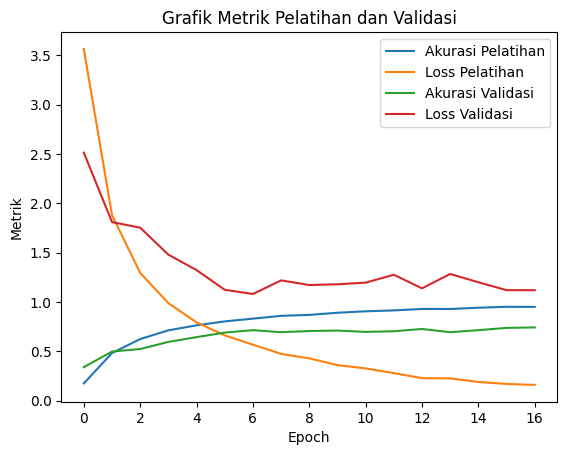

In [10]:
import matplotlib.pyplot as plt

# Cetak metrik pelatihan dan validasi
print("Akurasi pelatihan:", history.history['accuracy'][-1])
print("Loss pelatihan:", history.history['loss'][-1])
print("Akurasi validasi:", history.history['val_accuracy'][-1])
print("Loss validasi:", history.history['val_loss'][-1])

# Plot grafik metrik pelatihan
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['loss'], label='Loss Pelatihan')

# Plot grafik metrik validasi
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.plot(history.history['val_loss'], label='Loss Validasi')

# Tambahkan label dan judul
plt.xlabel('Epoch')
plt.ylabel('Metrik')
plt.title('Grafik Metrik Pelatihan dan Validasi')
plt.legend()

# Tampilkan grafik
plt.show()

# Test Model Accuracy

In [11]:
# Evaluasi model pada data uji
test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc}, Test Loss: {test_loss}')

10/10 [==============================] - 20s 2s/step - loss: 1.0441 - accuracy: 0.7548

Test Accuracy: 0.7547619342803955, Test Loss: 1.0440864562988281


# Save and Convert

In [12]:
#Save the model
#!mkdir -p saved_model
model.save('saved_model/val_acc')

# Convert the model
path = '/kaggle/working/saved_model/val_acc'
converter = tf.lite.TFLiteConverter.from_saved_model(path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('food_val.tflite', 'wb') as f:
  f.write(tflite_model)

# Confusion Matrix

10/10 [==============================] - 12s 1s/step


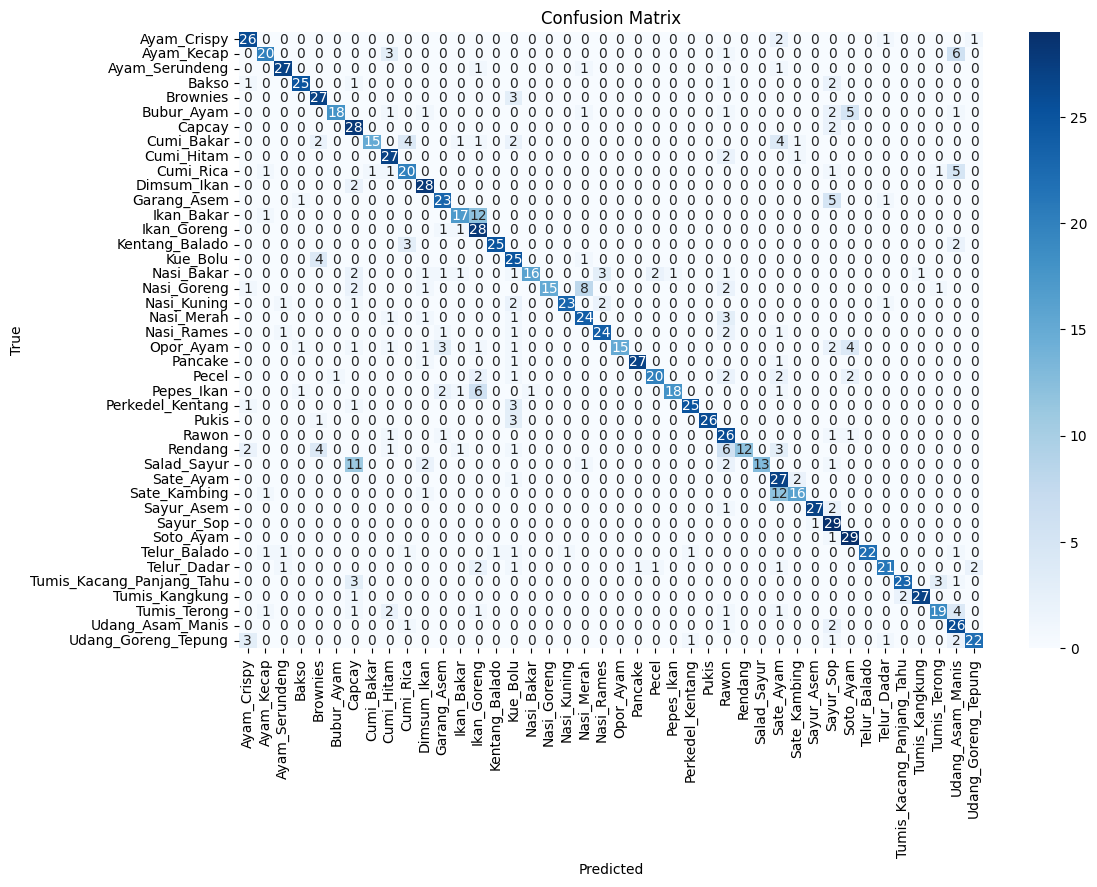

In [13]:
# Prediksi kelas dari data uji
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ambil label yang sebenarnya
y_true = test_generator.classes

# Dapatkan nama kelas
class_names = list(test_generator.class_indices.keys())

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix menggunakan seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Mendapatkan prediksi dari model untuk data validasi
y_pred = model.predict(test_generator)

# Mengubah hasil prediksi menjadi kelas yang benar-benar diprediksi (0 atau 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Menghitung precision, recall, dan f1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Menampilkan classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes))

10/10 [==============================] - 11s 1s/step
Precision: 0.8131583322124503
Recall: 0.7547619047619047
F1 Score: 0.7562316787551897
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        30
           1       0.80      0.67      0.73        30
           2       0.87      0.90      0.89        30
           3       0.89      0.83      0.86        30
           4       0.71      0.90      0.79        30
           5       0.95      0.60      0.73        30
           6       0.52      0.93      0.67        30
           7       0.94      0.50      0.65        30
           8       0.71      0.90      0.79        30
           9       0.69      0.67      0.68        30
          10       0.76      0.93      0.84        30
          11       0.72      0.77      0.74        30
          12       0.77      0.57      0.65        30
          13       0.52      0.93      0.67        30
          14       0.96    

# Test Manual

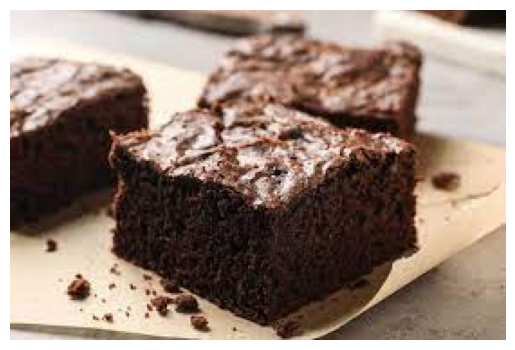

1/1 [==============================] - 1s 1s/step
Prediksi: Cumi_Hitam
Skor Kategori: 0.6155013


In [15]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import urllib
from PIL import Image

# URL gambar yang ingin diuji
image_url = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoHCBYWFRgWFRYYGRgaGhwcHBoaGBwYGhoZGhgaHhgZGhoeIS4lHB4rIRgYJzgmKy8xNTU1GiQ7QDs0Py40NTEBDAwMEA8QHxISHjQrJCs0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NDQ0NP/AABEIALcBEwMBIgACEQEDEQH/xAAcAAAABwEBAAAAAAAAAAAAAAAAAQIDBAUGBwj/xABAEAACAQIEBAQEBAQDBgcAAAABAhEAAwQSITEFQVFhBiJxgRMykaFCscHwBxRS0SNy4RYzgpLC8RUXJENistL/xAAYAQADAQEAAAAAAAAAAAAAAAAAAQIDBP/EACMRAAICAwACAgIDAAAAAAAAAAABAhESITFBUQNhE3EiMpH/2gAMAwEAAhEDEQA/AOrRRGnstJ+HSKI7LSSlSClERQBFa0OlMPhFPKpzU21KgspsTwVG5VSY7wxPykitmaQwpjOYcQ8O3QDBmsvf4TiFb5Jrub2geVR34eh5ClQrOL21vJ8yNUq1xEj5pHrXV7nCUPKqrGeGLb/hFKilIyWG4rpo1Pnjbj5WqTifBcfISKpsV4bxCfKZqHEtSZOPiW5OutSrfimNwayV/CYlN0n0qM2IcfMjfSliGbOh4bxQraGrrD44OJBrluCdydEb6VqsG1wJ5V1pYlZP0bfDXF5mabvYtAYBFcwxWIxRc5WI12FRr384upb60/AvJ1uxiFbY1INYjwZceJuNzrbhgatGcuhAUcUYpUUxDRWrXAqAKrwKkhoFDAsHRTvUHE8LR91H0pK3z1p5MTU2FNGa4j4MtPJCweo0rI8W8F3Ekocw6HeusLiRRFlbeKlxT4aR+SSOA3OHXEaXQr6j9apeL4oHQV6NxPC7biCBWYx/8PsO5JyCe2lKMWmVL5E1RwFqQRXYsT/DJPwyKgP/AA5jYmtbMWjleU0K6b/5eN1NCjIVHc8tFFQbvEV5Gov/AIg07ihtDUWW5WkFKosTxxkGwY9AaewnErrCWtxPKeXepseLLNrNMtZNIfiir8wIpf8A4ihEiT7UZBi/Q0yGm2qSuNtt+IU5CkSCIp5BRX5qPNUtsMDtTD4U8qeSFiMlqKaU1lhyps0WKg4pD2QeVLzUJoGQ7mBQ7gVWsmGDwxSfartwrSpMTWU4zwS2klZLtOs1MnRpGNlvxCzZVM6hdKz+FxT3JW0o9YgCqtOHXVU578LyE05hrd9JNpl9zWbabNkmkWuDwq23yOQXY0vi+FRCGuMMvSsoMViFu5nhm6zUjG4j4oCuCzfai0KiSnEUZ8llvpVlgcZdRiGbNVTgMCwZRatgHmxrX4LhxthnuQSf3FKn4ZVryiFa4+6tDqYq0bjtsDUxUfHPbCSEzHoBNZLHOzgeQqB1qrkvJOMZeDcWuO2j+IUjEcftAHzge9c7uYrKpINVDYkuwB2nftRk2H44rZ1Gzj84OV9aq04/dtuQ3mAPKs3hlcuFtMcoGsVH4groxZWLNzFTkPFHU+FcXS8sjQ9KsA/SuYeAb73LrgzpE9K6G1thtWi2jCSp6LBbxp5MT1qoF8jcU+mIBpkFqt4GlZVPSqwP3ow5osKLD4S0KgZ260VFjpGbx/x7hCKMiH8fMUOH8GhvPduP9hUu9ihdc2rctl3YDyj3q4VGRJzL3oqzS6EYbBIp0UT1O9TLKhBqZqIMWpEqQxPTaqbiXFVRv8QkDkBqDTtIVNj/ABbHB2ygwi6ljz7VGxPiFEAVCGnoRpUNcUl8FQhAO0iJpWE4BbVc7gCNYqbvhVJdM3xLjF0vFlMwnUxVlhuK4kJlcZVPMbim8T4ktWiQiKTPYVQ4zxcdZVQTyqP0X+zW8K8XfBORma4s7nce/Ot9gMWt1FddQwkV56xvHiw0AB7V0z+FfF3uWSjgwh8rciv+mtNWiJJNaOgFRSXsg8qXNFNMyI7YNareKsLKM52FXVZXxBig91bMZgdTH60W/BUVb2Z2zxT41wPJAXkKtL/D2uEO7kLyXn71LtYG1ZDOQAN6zXEfGlkNCSx2EbUVXTW74Hj+DITDlgPWlWeHWgAqFvqakYG618rnhQddTrFT8Y9pCEWDG8dOtS0UmUj8ORJJkk7GaXw2yEU6ST1pzHrBBWCDrvVbxu46ZHQaT5gKllKqF43ij22gKAN6kcN4/dxJFvLlX8THoOlU7Il4yzx71M4ZwuSxRzCcxsaSdDastOJcfFoFEQmNMx2n9axHFeKX330BOgFavGYJ8QqqTlHbf60beH7Vq3mckty5601JsVJaMamFcgZ51onta5UknoNa29/An4asxVE59akYGxh7Sl1AJ6mjYqVEHw0Gt2jmSW60xjr8o7MgU6xVhexJ82RGPU7Csf4gvvAltTypvehqls1v8NgpVz+LMZrdFqwX8Nrf+GzcyTW2JNbR4cs/7D2UGiayKaDGnM9MkauWyNqji64NSyaGSlQyP/N9qFPfDHShRQDeGezh5QEADWKgcUDXgFWVQ8iYzdgK5pjrr3RnQMqk5QSSQTzroPAOEPYtq7l7rwMvxG8qeg5VEW3o1aS2T8PglRQGPwh/ToJ96Xi8XaXU5DHMkaVm/GOKHkNxiXmQoPlAG9c+4/xj4zQpyouy9e5ph9s1viHxYmXJYIzz5mGgUdutZfEeJ7zDKXYj7VnjcPrSDcgxFPEWdEq/imYyTvTbW8xk70RbtpSGuEGmgb9jkgV1D+GGIQsqrcacuqcpn9/WuWs+lb/+EcHEMCJhJHbXX9KmS0NHa4oRSbrqoliABqZMVmbuOuXWzoXCSQpHlBH9RB1PakZpWX3EcUqIxLAGDEmNa4ph/EWJTEPde25UtGxKgk6a7VsMaBefRHYSQS4gRtzpWI4KmQqkjkVUmOxjaaW7s2iklVmV4jxO5i7/AMFLpGmqhZk8wKdwHhhgSzWyAD+KZPemMJwdbeOTLd84aHAIDCRzPOtv4t40loIjXAjb69OppJauxt7qjPYnhZRxcD5co2O3pT2GwhuOTZaWdSGI1Cjqap8RfsufiNiTBiQATmk8gau+DYrDWHzpdcMR8rbZeuXeO9RVvZd0tEaxwC9YWM3xMp0knUdJ5VmuPcYvbfCKKJkRtXT0YXMzkm2ZjzKQjD8JB22qNdW2rCYuKG1IAMmNo6VdInJs47h8aG1LlTO3Kth4T4qEfK7jIasOK8D4diSwU/CuAycikkew3qgx3gG8iZrNz4nOAPw8jprT/iL+S6joVziVvKcmWDsdKzWL4ugfKzSAfWuZ4nFX0JR2YFdIOlJscRdWmZPem42QppM6RxDi1u8uRVYgfiMhae4RctP5XdSV2E7AVzy5x+4wKmI6AUmzxRACGTU8wYpYstTjR1g8YQu6KVhV3kRNc44xiS7nWfSqzD4pc2mYT3p262s0VvY7WOjr/g3BlMOum4rQkGqXwjiXfDoWWNBV8WrVcOaXRozSVmnyaLNToVgUUdANRikAmKFOUKAOV8b4jhrS2jbuh2ttrbX5fLsT9KicY/iHfuoUUKqkRpMx61hy0z6U2shalRNZSJmKxjvq7EnuSdOlRo1miQ6a0kk1VEN+xx0NJZJ1oK52NGx5UA6YuwAGXOTlJGaN8s6x3iavb/hh2ZjYl7YEhjCk9iJ0PcwKz4QkgDUnQDudq1j8Z/lrotKgIRVSGB+aBMg76/maiV3o0go08gsN4SGTPdvqggzAJVW5AudD7VqPCj4bC3Q1t8zugWFBbOw3gdTvvypFjGtiQme+FVwQLdu3ny9mMQpOprVcB4Das/4hSJ0UsQzEDc6bT2rOpSfTVuKXCdgv/UPmuo4CDRWQgEn8W8GpeJx1hS1oEM0eZFOoB016b0eFRlLDOGRth0HruKznjS61tUNpAM0guoEgSNJPM71pxGNWwYnHYezbyplktCopLtBPrqfWrvguFuZSLwlWEgEhiAfT1rL+F/DpBW5dtuUbzKCyluRBidjV5xnxBeteVLVtAdA928iKBttJJ9BQq6DviMJb4AjcUZFuMgBLoM3mcLBADHaCftWtwXhJC73L6G4zE/7xs8dI5VmcTeRH+O7i7c+JNvKGS2JkEKxBz/i5gfQ1dv4hR7qWhYuKWBy+fyE65ZC9ep50lJGji2JxXhJFV3SyiNrlNvzsPSTC/Sk2eDYX4qXQXS8pIyt5VbKNQynl6U9fOOOYoUSFgKqtcbfkZA+1ZI4C875LvxHY6iWMKV0J7a+gpO+pAq43/hsfEfib4eHJuIFJfKg3DiNZEeXn9KwGP8YXGOVFVEIiFUCR07nWtpb8O3rltpuB1DZURgPOqnUjNyOkGjHD8tpUKIjrcghUWSo1EkkDly7Uk3e0EkqqLKbw5hcRfslkfVBlKEQ0cxHPQ71ZKHS4iIXCnUsVymYAjMY0371Z8Hwlt3PxbT2riGc+aGYHlKnUdqvMfgfiIUVGZIJ3XNI2gudD32qsU+CUmtMxeP8ACov5S6NJzyRB21WGkEk6iIqr4V4Zwrq+ZCwQMYMq7HdULDSNDr6VtWwzphvPdT/CQs7LJcHd1BEQO9UV3B5MOl13VLbmQFYu8tJCk6awJO8Gs3a4aKn2jE4zglkjIiPbcEyWfMh5wNJ7e1Fd8DXEQM962GcwiLmd20nZR5RFXV/G2WeGDoQMwYgEMuoPlUyNQanYfFIXQW7gRAZBAIYaS2kTvNOM2gl8cXxGIxvh+9bynKzrlBLKrQDzB0+9MEEkV2PC8atXT8I3bfxmDAEQUhNfl03A596wviLFYYtmXKwBjOsgkdQvMSelNtkqK34Lfgni34aKjLsK0mE8To/OuYhOhkHY9qn4FDNL8jRDgjqtniCtsafW8KyPCwQBWjwp61S+b6Ifxk9WFLDUhLQNGcMeRql8kSXBipo6R8BqFVlH2LBnmsL3ojtApRPtSGFMphx0oKe9FSSaBWLnWkk0FomNArJGBxGS4jf0sD/r7b+1KxrEs2YnMDow6dT1POahEVLw1rOrkAnLB9uevKhpJ2NSbVE7gfGDYYEyV1mGKsRGmx7Ctcn8QrjBbbW0MEsrAlSAZ8sDTnvXPETQk+n1pTOsiARH396HFMFJpHevDuMtXVdgIEy5kLBgFiddf83aq7jvH0Z1sm0biw5RbcslyDCElZIgAzB3rlGF4q4QKzHI5hlDZc4BkBuqydv71sMP/EFLC/4WGGdtczsrZRqFHkAJAAWBpE1ni+GilHqLvBXuJXAfJ8C2NQCUQhB+FU37aihw/wAGWmvfFxNwXXGUm2YcjMSAXUkmNxzHln0zX+3Ie6jumVVPyrqWBEnMSQD5svLRZA73WN47ZVfj2rxLXFCOLfkCRJVCrAQw15zqeUUbQ1Uif4mceRDaQqiAi4SVUBzlYIAvngATBgArAM1QeGitq9buLkuKGywxClQfmaCfLlBB0kb0gNccoiE3QfM2a5LLnXMSgJIAA3HeAdKaxOFAItqhzMWGcZlA0kyNZA117DrUPpolqjqtzi2FUsMyiBJI0WIzHUaE1U8Su4b4H8whJRgAGRc2mpI1kGAGn0qjw+GweCTPcu/FuDYZG+ZhoqDbkZJI26VX3kxty0XvugVhC2mBBIJAgKg8oJ5t79Kt35ISXgl4TjhusFXPkgFTGT5fKTmX8OhHOIPSpXG8Mxv27uHd4+chIPy6OWLL5DAI361lrfDWa9bP80RKhfhea2S0Fii+ZpWSTMamdBqRvMTw/wCBhUSSSBmNxgG31H4QJjy6chJnShxdaYKW9onYCcSqXNQQ2X5MrkA6s2cwV9AarrXF8144bDoztPnYsVSJ15cu3PSoljxCuGRxbR2WQFDRo7DMGkwSDlOg6A9qyV3irWRfuhiGdHXeFHxOkGZHTtSvgV30XfH+KWkzp8VLkyHLGQQSAyKvMaHrWL8Qcd+IlpMuULOUSWyBgNBJkHRTueW0mq65iFysLQiSM3KZ5AbRP5VBTC5mGYwpE9Y/701FXbJlN1SLjF8TFzKSMjrqGAjXYAjuAdO9QcJjGRizADKSdBGpEEHXXfbvSEQASNR9dRGuvvTWJuFtDtMA9aaS4JyfWLweHLFnjQBtdhJ2I6U41wSAQZB013PKlWb5RSsiCYIHTtTd0kEEgGdoo6xrSNCi7b7D2PSrvhtiY0qt4XbD5csnvlIGnepWL4yLLFAPMOdc/dGrRssJaIjSrewh00rnfDPFF52AVQevKukcKvF0ViIJ5UVQmqJttKftzzpC04GpkiqFFQoA8uFjR5+tIfTagp0rsOe9iiRSY0ohS0QnagOhUoWSakW7MDXenLZmpchqNjSYXrVrg7Xw7LvJUPCqdJaJzAdoptMK0ZjovWi42QuRFMgKNY182+o+lQ3k6NYpRtlVcEk6EDfr6U41yR5tQd6Qm3p9wOVHcuAz/fl0irMg8qwOgBI+u33pt8pJy6ADTuQKWhEiBMAxP1pFvTNqNR/3oENqpj2n7xUy5bygBjELOnmBJA0GsDfftSbd5wPKYA9Om32P1NIuJJI35AxvG8H6igdJIew+Ia2c6uwIAjKcs5hrOunLrNXeH45cyEM7MjjbyB11BBkESJ9I10rO4bLBlZMxrsARA0+v0FIR58qgak7x+wN6HFMcZNG6+MoS3luBySCwIIZSD5dTrsee06EVu8Pimu4YOhDsFg8jmiIYTBPmA6T6a8d4XeRWT4oLKGWSDBI23PygRvB61r8Z4ystcCJbFtAYzKTcDlZCsARoNI22OpqKo0tOi78P2raFblxkDMzyAAGSBEAnUswYiBPPaleM/EJc5A2VNJ0B5mZGpH01msni+NecPbc5t82QAJmnOANIMFhI5EVScZx7O8tBOgEbHlPpEacgKStqhyqLskYviBEjYZg0HckAbnYbbb96r8VfzsxYxsBlJy6CDpPXr3ptZEyJLfbnTaqsg8iIM6SdzVpJEOTYtx5cqgjb9aJyGAEwf3vS52M6A6R+UfTXvTFk6cj3oHQTuACBygRyjmR70vJtlgbc/uO9EbYJ026A00QQwA3oE/sf1EKok9x+tOogZlWY13OgEmmbrRLbEaD/AF60lGJg9alopPdHbuD8OQW0FshkCwCDO2+tV/G/BS32zhsp/OrzwspXC2RAP+GuoEcqtgG7Vzo0b2YLh/g97ZgkEdedbTChbSAEwB1osXYcwVYzOvpUi3w9SJbXsdftSSdibE/zycmn01qRYUvB1VehGp/sKftoi/IoHoIpammKxc0KKaFOwo8sKs0Ftt0rb4rweUPkM+tVzcAvTqnvW/5EZYlElgVItWSdFFaDDeHToXMT101rS4Dw+FGopOQ1ExeG4O7byBV9g/DoI+Xetjh+FgcqsbODipbbAzI8NI9v4ZBA7b1gvFPB2sXshYEC2COsTA06127+X00MGND071xHxZedsS4LlyhKhiIJA3EdjNON2U9oqMpkKTppI/WmbcGdv10o8mu++u9Hhk+baDH51qZscVQGgSSJP0Gw/tUd/LII579KeS25HlGpkDUSRoYim7tnQbzrM+2nrrQJjqJpuTMHsP77nSiugaDkOh11ifefzo3WIGoA5TI5nWmhOmo36x99uVANBWLbGYiCIM/WRFAgDWAT/Y70YjQdY1judqM7EbwNSdNdY/WqFQWbTYSQeX5fU0hHKnQwY/OKNH9dB68+dAJrsZ7advzoAlhyBvzIHPSInXnRIvuRpGhjTX3o91E77fQaa+4+lEGgHSe3XX19aksIvqWkaQNPTr9aS8KAAQYbn6CRS1Go26mJ/WkOkNmOx1H6Uh+BdyNI57D15/vrSQu4GkffWDrQcwORkT0Akbbe1JD6AHlQALAOYxsP2KcSA08+dIV4kUkqeZ1/OhgtDhXNOmnIUeDSYUzr037xTbHczSkbfXTYTSfClVnoPhaC2lu2iEILawSdRpsasqofB+ILYKyScxygT6etXbvXPwtgQkEzHaP1704LnOo+eh8SpbAko1OA1CvYxLYljryUbn2qnxXEnuafKvQbn1NOgL5uJWxpnFCsv8EUKdAWDcOFLTh4q5Nqh8Kqozswfjjgz3LSLZtu7hp8pAAHfWrjwzw+4mHRLw84GsmTWlCUoJTC/BBWwKUbdTMtINvXT3oERWUgEjXTSuCeJ3Y4m4xT4ZLEwd9a9CkfSslxngljGFmykldBcBEHnII3g9aFKnZS2qOHqYj+r8hFBvxESNvpWu4x4KuWgSgNyTygED05+1ZZrRDsjyp6EQZ7ztWyknwhxaGLZkzEx7R01p0Ez1jTvTTaLAO5+o2pSMRJAPKOxG9MSF3rbERzn/L66H0pKiJI1IGh2196Q2YxBJJ951pd2TAk7wTP69KAYgKI1J6x9ie21NMTm8o35U6gB9gB6n60pXJk8jAmBPt2p2TQMOrAMf0mSP01NJRjPeZ9DT2EJmY+UdY11IgTrtTSGd5JJgAH7/U/nSHRJZhoCY/ev5UkmNZPf15j8qJtQefpy9Kad4BH7jnQUx7OdSP3p1570gueWw01/SkTpp7fqZosw31k/uaKCxTnWPp6daAbfpRMNvvNJH79aAFjf7mkEc5NEh1nvT9nCu0aQOu1D0HRvN0qThsI7gECNdOc9orWeDPClvEM5uMxS3lkDQsWmBPIDL9xXR8LwbDWipS0gZQAGPmIg6HX8XfespTRSQx4Ot3EwyrcQJHyqAVMf1FTqvoauXeo73uvqapeI8fRCUUhn/pB29TyrB7NC6vYkDnUJ+In8P1P6VSW8WzmWP8AYVOsmarEVj2XMZOp6mnAIokNLBp0KwooURjqPrQphZsSlArS4oRVECAtJLaxB2mY09J607FIuyAcok8htQBm/EvGntlUsPb+ICGdbgY+T1Gin1qz4VxS1iFLW2BjQjYg/wBu+1cQ8R4y+r3EdHR2bzsWDMwjQE9PSth/Cq66rcds5QIADlkQJJCxrPYdqlX00kopUunTbluQQRoRB9KqMHwZLR/wiQmvkmVnmevKrfE2A6MpJAZSJBgiRuOhqNw/h6WUCWwQok6knU7nXqdabRCeivxWGB9ayvE8G73Sj2Lb2mgBzAcaa6H5iI+9a+9wsfG+MHcEqFZARkbLmykiN/MareJLfF0BLYdMjNJIBFxfkXXr6VLLjRyrxP4dFlwltxDebKV1UbaNGvpWcbNbXXQmJ1nbqK634hsJirIXPbs3soJDNBWfmQnpP5Vh38KYi04a+LTpqINwgMP/AIwM3fQVpGWtilH0Zl3aYIEzy6aadqQQZnQ8479/StNj/DaFh/LOHzAk2y/n0H4GIAbfbesy+FZXKkMCpghhBA21FaKSfDNprou5ogEiScxAHbSfvSEOwAmdQfz32pGXl03+mn3pzDHK4jWPz5fpTJsS8DTfr6yZ1pdu0Np1jTbrz9qQ+WTqSNxGkk77+lKA8xzTyK7nQnr3mdaAS2Emhy8x/ejuQfU9qIgDUjf6RSGncUB4FTtv0pLEyKGb996C67UADkaABOwNTMPgWOrHKPuafuYNepA2Pp0qXJF4sh4dEJhmM9tvrVwibKoPQADWeQFRrWFRdh+tbnwRwXUYm4PKv+7B5tzf0HLvryrKckVFUafw3wv+WsKh+dvM/wDmPL0Agexp7ifE0tKXdgo6ncnoBzPYVn+P+MESUsw77E/gX1I+Y9h9RWJv3bl589xix78h0A2AqYwb2xuVFzxfxRcvEralE6/jYev4fbXvULh1gTPP60nDYcVYWUitKSWibss8MSBqKtbT1VWHjmam27nee1SMskvCedOG8KrbN0tyI61MbsTSAdaD+H7UKjWzAAltO80KAOhxRFRVMvinDf1t/wAjf2pxPEmGO136o/8A+au0SWpoEVBXjWHP/vJ7mPzp1eI2Ttdtn/jX+9AFdxPgOGfM72lYwSSEljHYCSanYDApbUBBC8gBUlbyHZlPowNM42yzoQjlGkEOACRBB2OhB296T0HRX8sM+fXNly7mCJnUbT3pbMAQOvYxp1PKs94k4Xir1pRbvBXWJyjKG3zyDO4Iido5zV3w0OLSBx5wqhtZkgQTNJMbWugt3M4JggAwNiGHJgRuDVD4mFwhLaIStwlWdcxa2wKlHIH4ZBmr/C4RLa5EELLGJJ1Zixie5NRm4epvfGls+TJE+XLM7dZA+lJrQ4tJ2cS4rhXXE/y9w5FVgrvlKyrsFZlWJY5ZIiasPFXClwtu38F3cMGgsBlE7mY0bbTfX2rpvFfDli+63HTzrs22209akDCALlIkdxTKcmzzq2LuSDLSDIM8wZB+sV1r+XsY2yCVDZgJIGRg3MjmKHjLCJYRLiWwAC2fKi66DLmJUwJJ94qB4S44b174REjKTmARQpHIREj2JkjlRKV8BR1bZmuP+ELqZfgA3EB5xmUdCD8w/cVm7+FdXylSrINVYQ2vTr2rvF3C1T8V4FbvAB1JjYhijD3H60R+RrpLimcVVCJiD/8AYEb6UdpJJynUDWRy076dK3HEvArD/cvm55LmntmXQ+496ymP4TdtvDo4cmT5TBB31GhFbKSZGNEFuQFEvSJP1qfawO+fTl016Enb6cjT9q6iyqAwPxafcn96UnL0NRGLXD9i503j/WpCYVQRlX3p5DpqSecnejCk6AVm5MpJCMgmefWl27ZYwKtMDwZ31IgASTsAOpOwFOX8bbteWwFd/wCs6oP8o/Ge+3rU7fBt10XguGW7YF3FNCbrbGr3I5KP6ep2ouMcfu4gZEHw7UQEQ6lRsGI5dhp61WkO7F3Ysx3Y6nt7DpUyxhuoq1FLbJcrI1nDCpiYYDr6U8oUU4twyNBHSOVMQLKg/lUu2lItJOs/2+lS0TX96UgF20jlTyJ+9qJVpRbvSAfQUsuaZH7POizGkA5NCke/7+lCnQ7Nbd8N4dvwAemlRm8K2vwlh70KFb4oztkd/C8DyufcA1CveGrg/Ep9v9aFCowQ02MHgtwclMd4qBew15ZIEdIaP1oUKhxQ0xdvG4hF0u3B/wAZP2JNTMN4jxKjzXM3qqn7xQoVDGWFnxVejVUPsR/1U6PGIHzWf+V/0I/WioUDRIs+L7DbrcH/AAqf+qnP9qMNMFmHqh/ShQpgLu8Rwl9CrMHU7gq36rVTZ8GYVWF23mUgyAGIE/SaFCk+Ai8+DpUe5gENwOZzKpUEEjRokRMH5Rv0oUKkoDYfTn7xPrpUe5h96FCgDG+MeCOR8W0EBE5hsWkAAg7AwO1Zjg3hW9c1CqAP6mEAkzsJoUKtN0M2GA8HQs3mU8zHIfSoOK4rgbEi0husNNiig9ywn6ChQpR2yWUGP4vexHlZsqckQZU9xu3uabsYWhQrRElhZtRUhFJ/vQoUAOpaBIkT9tu0+lKXDg7gb6bz+9qFCkBIC/nH+lItqQdyR0/70KFAErKYGuvfX986JWI31P2HsfahQpALViRH7nnHanUNChTQDk96FChTA//Z"
# Mendownload gambar dari URL
urllib.request.urlretrieve(image_url, "test_image.jpg")

# Memuat gambar dan mengubahnya menjadi format yang sesuai dengan model
img = image.load_img("test_image.jpg", target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Menampilkan gambar yang akan diuji
img = Image.open("test_image.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

# Melakukan prediksi dengan model
predictions = model.predict(img_array)

# Mendapatkan kelas prediksi
predicted_class = np.argmax(predictions)
class_labels = train_generator.class_indices
predicted_class_name = [k for k, v in class_labels.items() if v == predicted_class][0]

# Menampilkan hasil prediksi
print("Prediksi:", predicted_class_name)
print("Skor Kategori:", predictions[0, predicted_class])

In [16]:
# from pathlib import Path
# import imghdr

# data_dir = "/kaggle/input/indonesia-food-hb/Dataset/Train"
# image_extensions = [".png", ".jpg"]  # add there all your images file extensions

# img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
# for filepath in Path(data_dir).rglob("*"):
#     if filepath.suffix.lower() in image_extensions:
#         img_type = imghdr.what(filepath)
#         if img_type is None:
#             print(f"{filepath} is not an image")
#         elif img_type not in img_type_accepted_by_tf:
#             print(f"{filepath} is a {img_type}, not accepted by TensorFlow")